In [15]:
import sklearn
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import pickle

import warnings
warnings.filterwarnings('ignore')

In [16]:
conn = sqlite3.connect('../db.sqlite3')

In [71]:
df_raw = pd.read_sql_query("SELECT * FROM scraper_auto", conn)

In [72]:
df_raw.head()

,id,bouwjaar,kilometer_stand,vermogen,is_handgeschakeld,is_benzine,prijs,url,titel,upload_datum,bron,kenteken
0,2,2008,117910,77,0,1,3750.0,https://www.marktplaats.nl/a/auto-s/fiat/m1554...,Fiat Grande Punto 1.4 Edizione Lusso AUTOMAAT!,2020-05-23 15:01:00,marktplaats,96-GZR-3
1,3,2008,169504,78,0,1,2950.0,https://www.marktplaats.nl/a/auto-s/fiat/m1556...,Fiat Grande Punto 1.4-16V Emotion 5dr Automaat...,2020-05-27 13:22:00,marktplaats,90-ZJ-ZN
2,4,2010,54430,86,1,0,4740.0,https://www.marktplaats.nl/a/auto-s/fiat/m1552...,Fiat Grande Punto 1.3 M-Jet Actual 54.000 KM !...,2020-05-19 08:34:00,marktplaats,68-NTJ-4
3,5,2009,211763,78,1,1,2495.0,https://www.marktplaats.nl/a/auto-s/fiat/m1546...,Fiat Grande Punto 1.4 NeroBianco 2009 | APK to...,2020-05-05 16:31:00,marktplaats,34-HZP-4
4,6,2006,359603,131,1,0,1250.0,https://www.marktplaats.nl/a/auto-s/fiat/m1558...,Fiat Grande Punto 1.9 JTD Sport (bj 2006),2020-05-31 11:03:00,marktplaats,58-TL-KD


In [82]:
target_names = ["bouwjaar", "kilometer_stand", "vermogen", "prijs", "is_handgeschakeld", "is_benzine", "upload_datum", "bron"]


df = df_raw[target_names]

df = pd.concat([pd.get_dummies(df['bron'], prefix='bron'), df], axis=1).drop(["bron"], axis=1)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_train

,bron_autotrack,bron_marktplaats,bouwjaar,kilometer_stand,vermogen,prijs,is_handgeschakeld,is_benzine,upload_datum
386,1,0,2011,24700,84,2700.0,1,0,None
231,0,1,2006,190637,77,1999.0,1,1,2020-05-18 20:14:00
349,1,0,2011,192950,86,2788.0,1,0,None
448,1,0,2010,72757,78,6950.0,0,1,None
302,1,0,2010,169615,84,3440.0,1,0,None
...,...,...,...,...,...,...,...,...,...
71,0,1,2008,182219,67,2249.0,1,1,2020-05-15 14:40:00
106,0,1,2008,156209,65,2950.0,1,1,2020-05-25 09:20:00
270,0,1,2008,109463,78,1.0,1,1,2020-05-15 07:01:00
435,1,0,2010,146846,78,4490.0,1,1,None


In [83]:
df_train['upload_datum'] = pd.to_datetime(df_train['upload_datum']).apply(datetime.toordinal).astype(int)
df_test['upload_datum'] = pd.to_datetime(df_test['upload_datum']).apply(datetime.toordinal).astype(int)

In [84]:
MIN_PRICE = 1000.
MAX_PRICE = 10000.

df_train = df_train[(df_train['prijs'] > MIN_PRICE) & (df_train['prijs'] < MAX_PRICE)]
df_test = df_test[(df_test['prijs'] > MIN_PRICE) & (df_test['prijs'] < MAX_PRICE)]

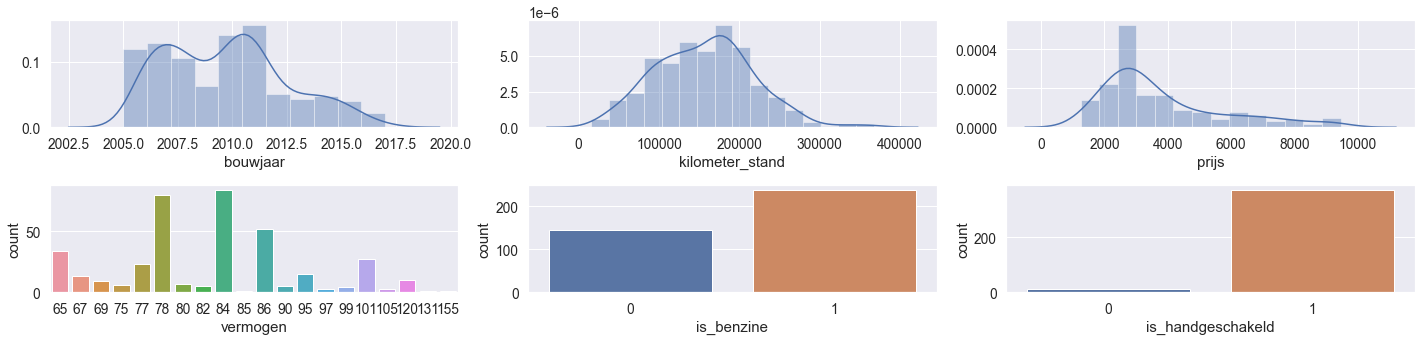

In [85]:
fig, axs = plt.subplots(2, 3, figsize=(20,5))

sns.distplot(df_train['bouwjaar'], ax=axs[0][0]);
sns.distplot(df_train['kilometer_stand'], ax=axs[0][1]);
sns.distplot(df_train['prijs'], ax=axs[0][2]);
sns.countplot(df_train['vermogen'], ax=axs[1][0]);
sns.countplot(df_train['is_benzine'], ax=axs[1][1]);
sns.countplot(df_train['is_handgeschakeld'], ax=axs[1][2]);

plt.tight_layout()

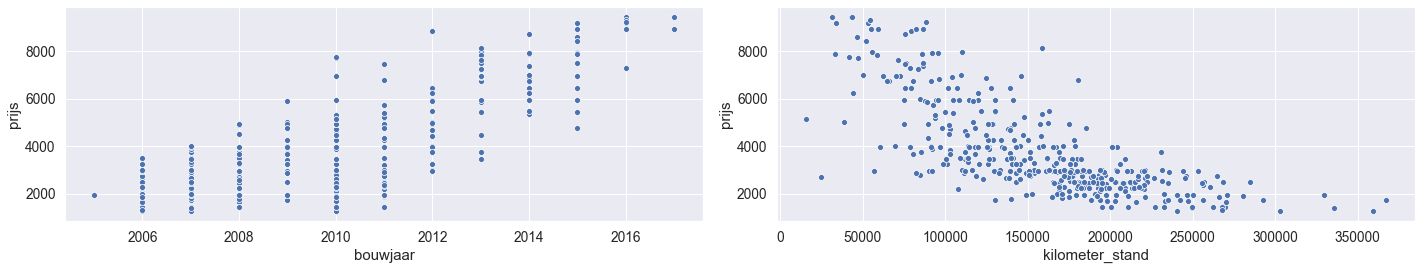

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(20,4))

col = 'bouwjaar'
data = pd.concat([df_train['prijs'], df_train[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[0]);

col = 'kilometer_stand'
data = pd.concat([df_train['prijs'], df_train[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[1]);

plt.tight_layout()

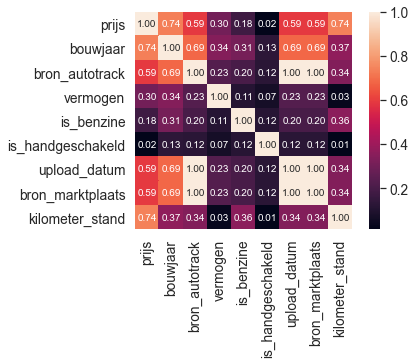

In [87]:
k = 10
corrmat = df_train.corr()
cols = corrmat.nlargest(k, 'prijs')['prijs'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
heatmap = sns.heatmap(np.absolute(cm), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [88]:
df_train.to_pickle("./train_data.pkl")
df_test.to_pickle("./test_data.pkl")

In [89]:
df_train

,bron_autotrack,bron_marktplaats,bouwjaar,kilometer_stand,vermogen,prijs,is_handgeschakeld,is_benzine,upload_datum
386,1,0,2011,24700,84,2700.0,1,0,1
231,0,1,2006,190637,77,1999.0,1,1,737563
349,1,0,2011,192950,86,2788.0,1,0,1
448,1,0,2010,72757,78,6950.0,0,1,1
302,1,0,2010,169615,84,3440.0,1,0,1
...,...,...,...,...,...,...,...,...,...
20,0,1,2010,217393,84,2295.0,1,0,737575
71,0,1,2008,182219,67,2249.0,1,1,737560
106,0,1,2008,156209,65,2950.0,1,1,737570
435,1,0,2010,146846,78,4490.0,1,1,1
